# 🎧 Blind Source Separation (BSS)


## 1 FastICA 实现

C:\Users\86137\AppData\Local\Temp\ipykernel_13776\2171836136.py:49: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, perm = bss_eval_sources(sources, S_est)


ICA 分离评估指标：
  源 1: SDR=40.16 dB, SIR=40.19 dB, SAR=62.16 dB
  源 2: SDR=55.88 dB, SIR=59.34 dB, SAR=58.49 dB


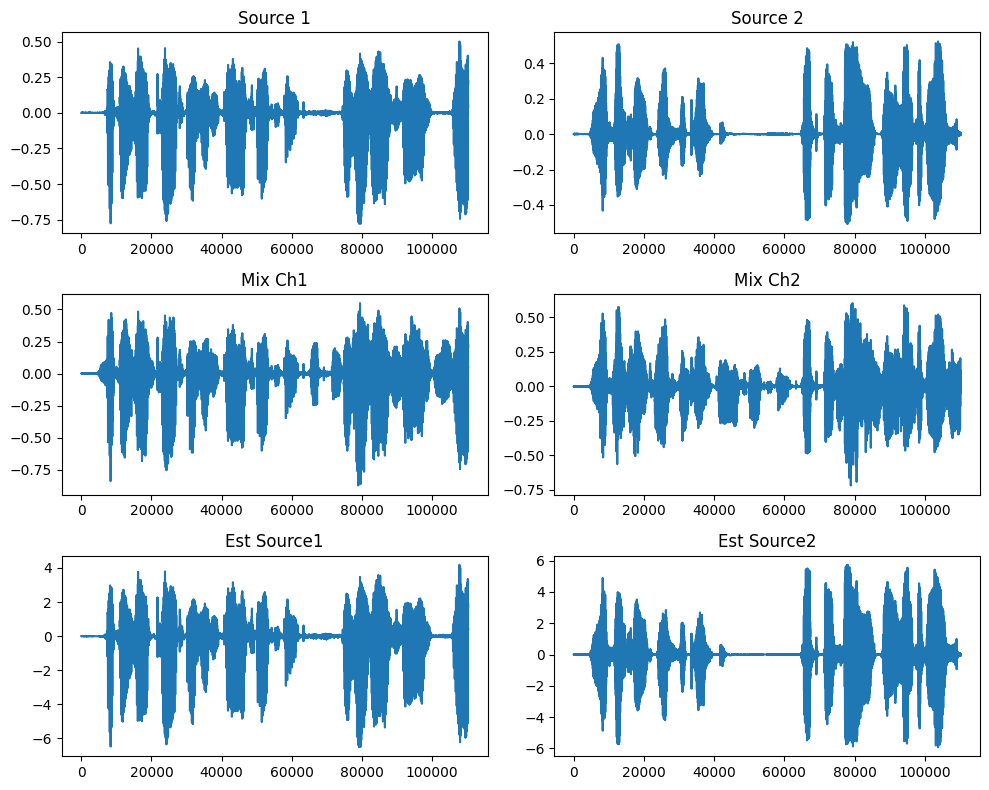

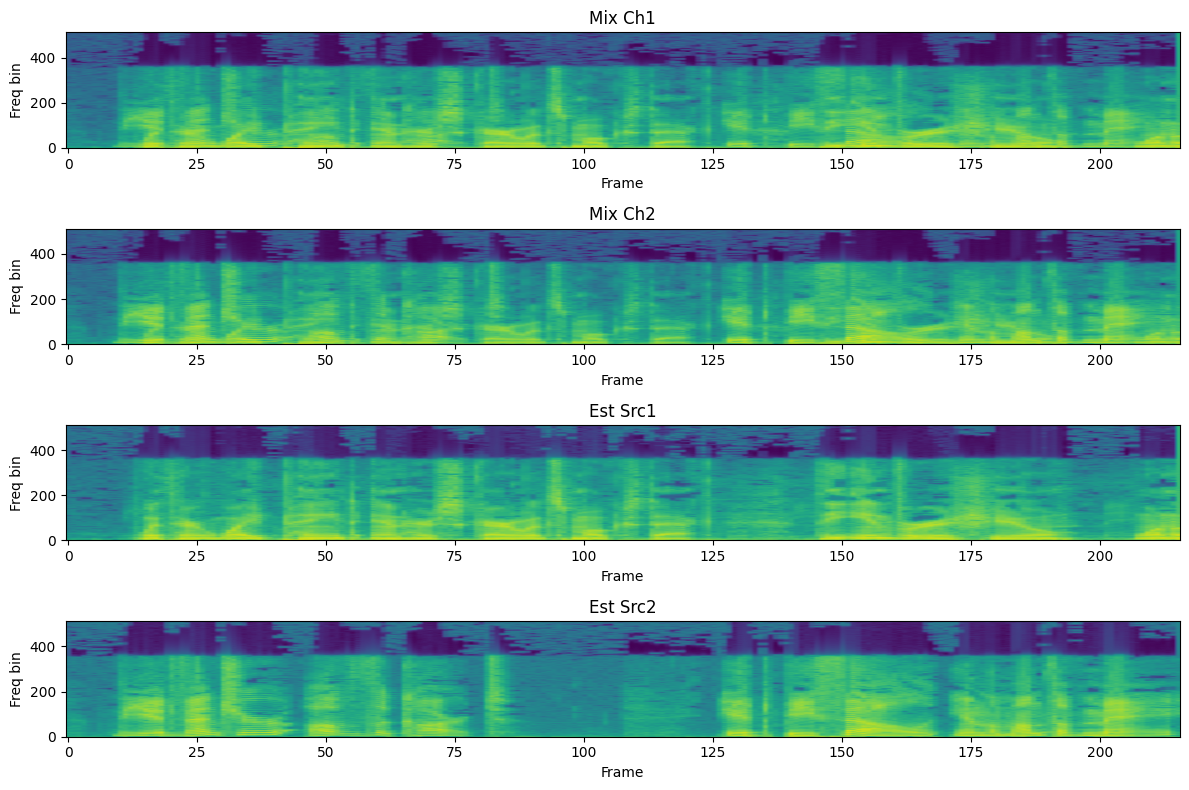

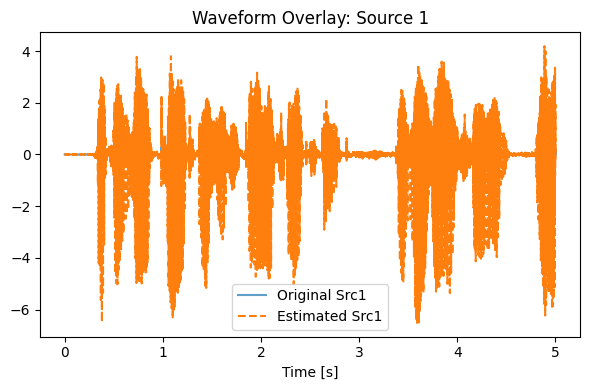

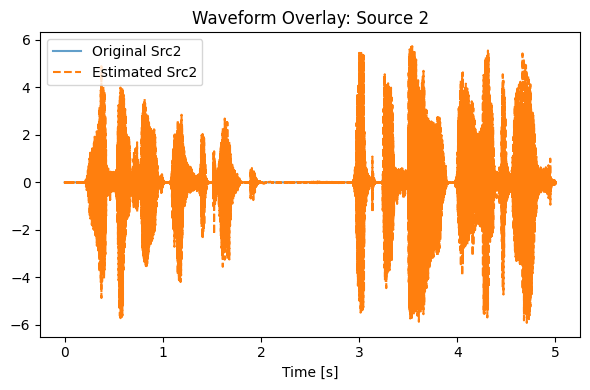

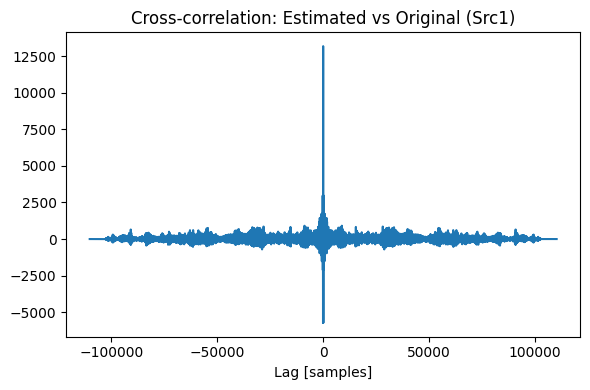

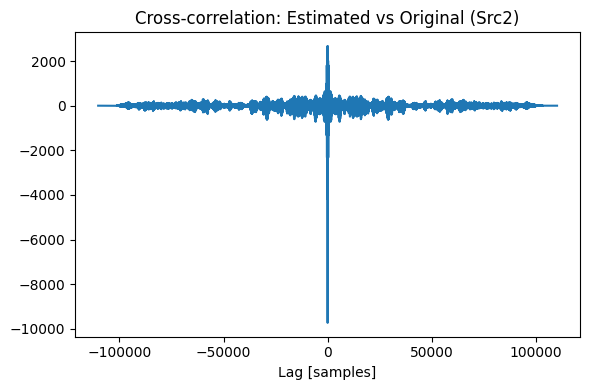

分离结果已保存到 c:\Users\86137\Downloads\results\separated


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from sklearn.decomposition import FastICA
from mir_eval.separation import bss_eval_sources
import os
from scipy.signal import correlate
import sys

import numpy as np
import librosa

def stft(x, n_fft=1024, hop_length=None):
    """
    Compute the STFT of a 1D signal.
    """
    hop_length = hop_length or n_fft // 2
    return librosa.stft(x, n_fft=n_fft, hop_length=hop_length)


def istft(X, hop_length=None):
    """
    Inverse STFT back to time-domain signal.
    """
    hop_length = hop_length or (X.shape[0] * 2)
    return librosa.istft(X, hop_length=hop_length)
def main():
    # 1) 读取两段干净语音
    s1, sr1 = librosa.load(librosa.example('libri1'), duration=5.0)
    s2, sr2 = librosa.load(librosa.example('libri2'), duration=5.0)
    assert sr1 == sr2, "采样率必须一致"
    # 对齐长度
    L = min(len(s1), len(s2))
    s1, s2 = s1[:L], s2[:L]
    sources = np.vstack([s1, s2])   # shape = (2, L)

    # 2) 合成混合信号 X = A @ sources
    A = np.array([[1.0, 0.5],
                  [0.5, 1.0]])
    X = A @ sources                # shape = (2, L)

    # 3) FastICA 分离
    ica = FastICA(n_components=2, random_state=0)
    S_est = ica.fit_transform(X.T).T  # shape = (2, L)

    # 4) 评估
    #  mir_eval 要求 shape = (nsrc, nsampl)
    sdr, sir, sar, perm = bss_eval_sources(sources, S_est)
    print("ICA 分离评估指标：")
    for i,(sdr_i, sir_i, sar_i) in enumerate(zip(sdr, sir, sar), 1):
        print(f"  源 {i}: SDR={sdr_i:.2f} dB, SIR={sir_i:.2f} dB, SAR={sar_i:.2f} dB")

    # 5.1) 时域波形对比
    plt.figure(figsize=(10, 8))
    titles = ['Source 1','Source 2','Mix Ch1','Mix Ch2','Est Source1','Est Source2']
    signals = [s1, s2, X[0], X[1], S_est[0], S_est[1]]
    for idx, sig in enumerate(signals, 1):
        plt.subplot(3, 2, idx)
        plt.plot(sig)
        plt.title(titles[idx-1])
        plt.tight_layout()
    plt.show()

    # 5.2) 频谱图 (Spectrograms)
    plt.figure(figsize=(12, 8))
    items = [(X[0], 'Mix Ch1'), (X[1], 'Mix Ch2'),
             (S_est[0], 'Est Src1'), (S_est[1], 'Est Src2')]
    for idx, (sig, title) in enumerate(items, 1):
        plt.subplot(4, 1, idx)
        D = stft(sig, n_fft=1024, hop_length=512)
        plt.imshow(20 * np.log10(np.abs(D) + 1e-6),
                   origin='lower', aspect='auto')
        plt.title(title)
        plt.ylabel('Freq bin')
        plt.xlabel('Frame')
    plt.tight_layout()
    plt.show()

    # 5.3) 波形叠加图 (Original vs Estimated for Src1)
    plt.figure(figsize=(6, 4))
    t = np.arange(L) / sr1
    plt.plot(t, s1, label='Original Src1', alpha=0.7)
    plt.plot(t, S_est[0], '--', label='Estimated Src1')
    plt.title('Waveform Overlay: Source 1')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    t = np.arange(L) / sr2
    plt.plot(t, s2, label='Original Src2', alpha=0.7)
    plt.plot(t, S_est[1], '--', label='Estimated Src2')
    plt.title('Waveform Overlay: Source 2')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5.4) 互相关 (Cross-correlation for Src1)
    corr = correlate(S_est[0], s1, mode='full')
    lags = np.arange(-L+1, L)
    plt.figure(figsize=(6, 4))
    plt.plot(lags, corr)
    plt.title('Cross-correlation: Estimated vs Original (Src1)')
    plt.xlabel('Lag [samples]')
    plt.tight_layout()
    plt.show()

    corr = correlate(S_est[1], s2, mode='full')
    lags = np.arange(-L+1, L)
    plt.figure(figsize=(6, 4))
    plt.plot(lags, corr)
    plt.title('Cross-correlation: Estimated vs Original (Src2)')
    plt.xlabel('Lag [samples]')
    plt.tight_layout()
    plt.show()


    # 6) 保存分离结果
    out_dir = os.path.abspath(os.path.join('.', 'results', 'separated'))

    os.makedirs(out_dir, exist_ok=True)
    sf.write(os.path.join(out_dir, 'ICA_src1.wav'), S_est[0], sr1)
    sf.write(os.path.join(out_dir, 'ICA_src2.wav'), S_est[1], sr1)
    print(f"分离结果已保存到 {out_dir}")

main()



## 2 NMF

C:\Users\86137\AppData\Local\Temp\ipykernel_13776\212561945.py:105: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = bss_eval_sources(np.vstack([s1, s2]), S_est)


改进后监督式 NMF 分离评估：
  源 1: SDR=10.29 dB, SIR=14.58 dB, SAR=12.47 dB
  源 2: SDR=7.62 dB, SIR=13.60 dB, SAR=9.07 dB


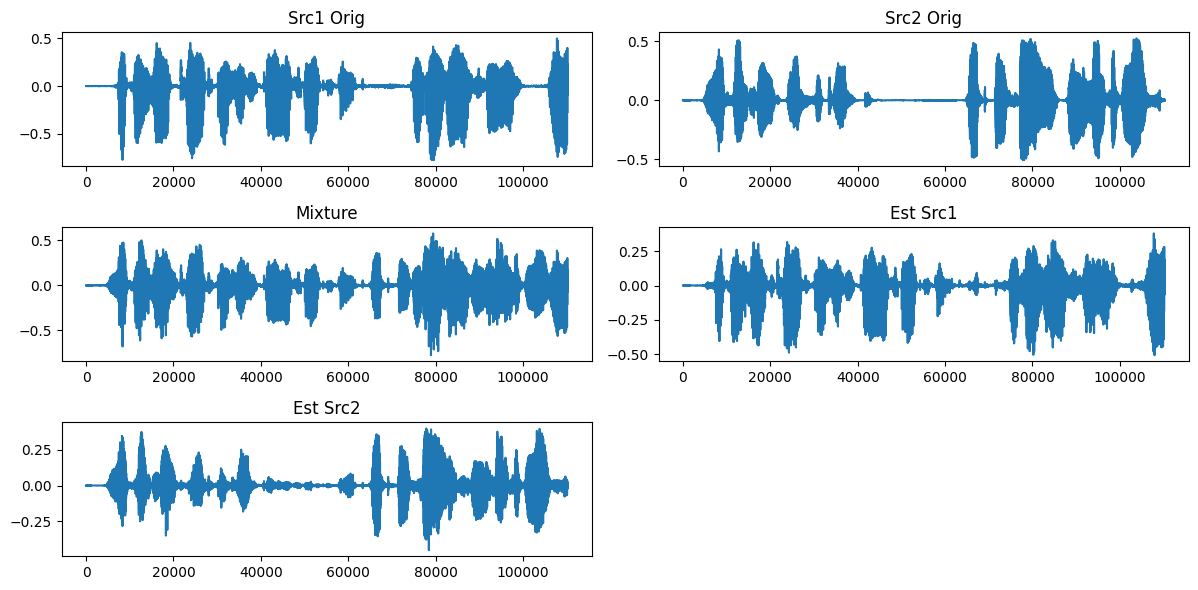

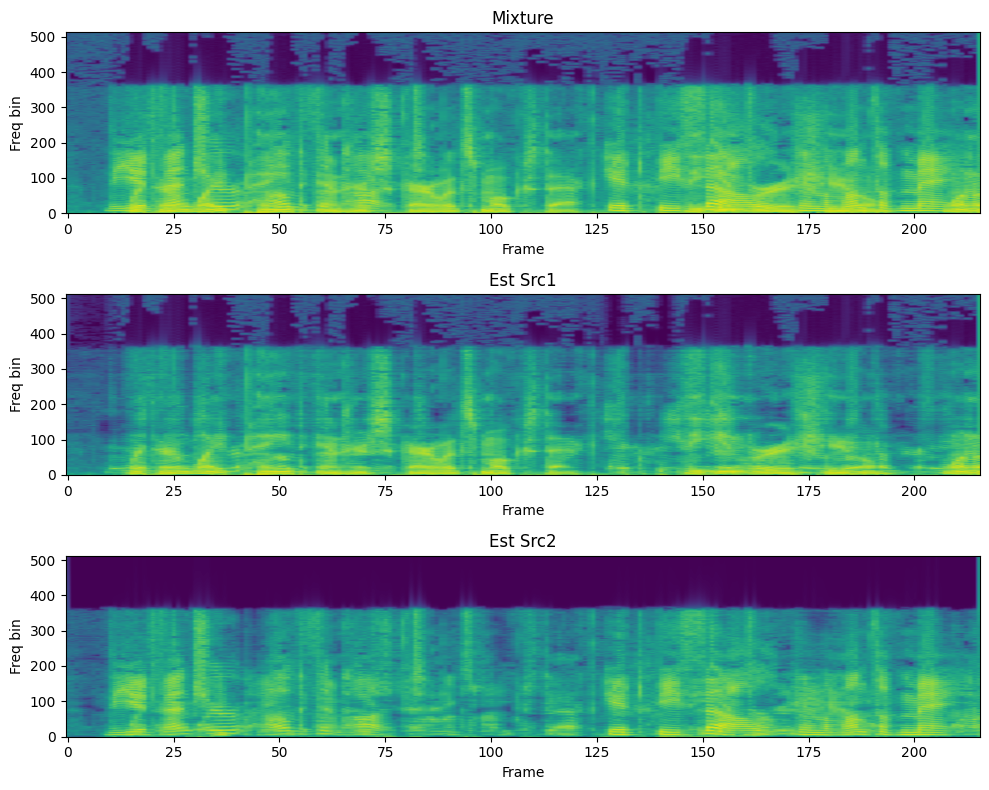

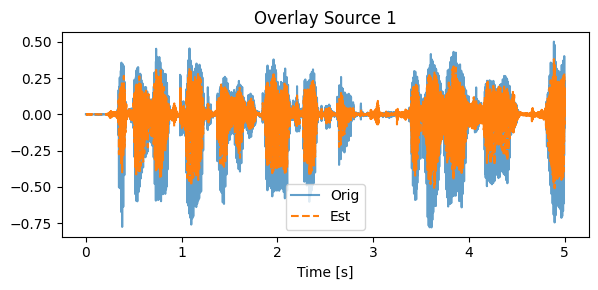

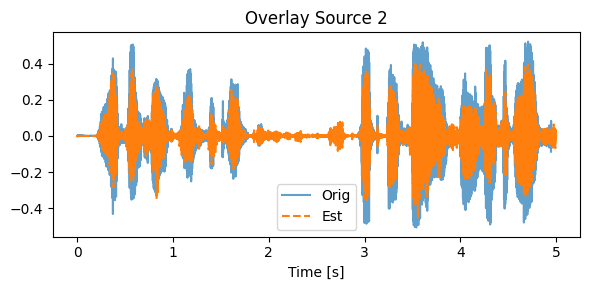

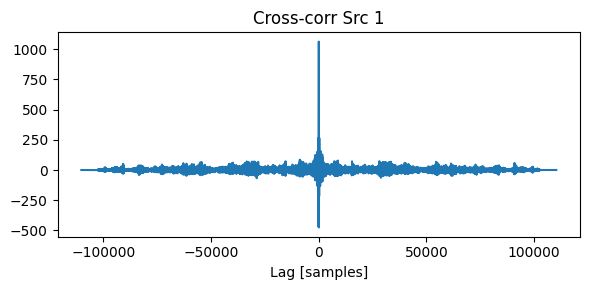

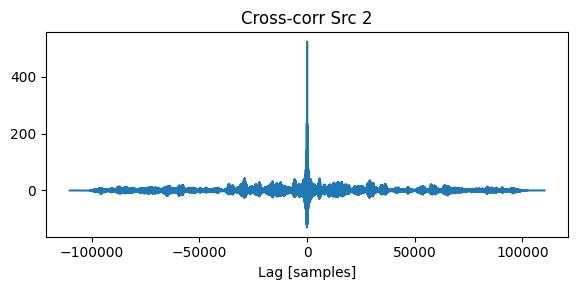

结果已保存到 c:\Users\86137\results\nmf_separated_sup


In [62]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from sklearn.decomposition import NMF
from scipy.signal import correlate
from mir_eval.separation import bss_eval_sources
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d
import numpy as np
import librosa

def stft(x, n_fft=1024, hop_length=None):
    """
    Compute the STFT of a 1D signal.
    """
    hop_length = hop_length or n_fft // 2
    return librosa.stft(x, n_fft=n_fft, hop_length=hop_length)


def istft(X, hop_length=None,length=None):
    """
    Inverse STFT back to time-domain signal.
    """
    hop_length = hop_length or (X.shape[0] * 2)
    return librosa.istft(X, hop_length=hop_length,length=length)

# 确保模块路径
_script_dir = os.getcwd()
_src_dir = os.path.abspath(os.path.join(_script_dir, '..'))
if _src_dir not in sys.path:
    sys.path.insert(0, _src_dir)

# 全局参数
n_fft = 1024
hop_length = 512
mix_duration = 5.0
max_iter_update = 500


def compute_spectra(x):
    D = stft(x, n_fft=n_fft, hop_length=hop_length)
    return D, np.abs(D) ** 2


def supervised_nmf(s1, s2, mix, L):
    # 1) 训练字典 W1, W2
    D1, p1 = compute_spectra(s1)
    D2, p2 = compute_spectra(s2)
    K = 20
    nmf1 = NMF(n_components=K, init='nndsvda', solver='mu',
               beta_loss='kullback-leibler', alpha_H=0.1, max_iter=500)
    W1 = nmf1.fit_transform(p1)
    nmf2 = NMF(n_components=K, init='nndsvda', solver='mu',
               beta_loss='kullback-leibler', alpha_H=0.1, max_iter=500)
    W2 = nmf2.fit_transform(p2)
    W = np.concatenate([W1, W2], axis=1)

    # 2) 手动迭代更新 H
    Dmix, pmix = compute_spectra(mix)
    R, T = W.shape[1], pmix.shape[1]
    H = np.random.rand(R, T)
    for _ in range(max_iter_update):
        H *= (W.T @ (pmix / (W @ H + 1e-8))) / (W.T.sum(axis=1)[:, None] + 0.1)
    H = gaussian_filter1d(H, sigma=1.0, axis=1)

    # 3) 构造掩码并重建
    Vs = [np.outer(W[:, i], H[i]) for i in range(R)]
    Vtot = sum(Vs) + 1e-8
    masks = [V / Vtot for V in Vs]
    phase = np.exp(1j * np.angle(Dmix))

    est1 = sum(
        istft(masks[i] * np.abs(Dmix) * phase,
              hop_length=hop_length, length=L)
        for i in range(K)
    )
    est2 = sum(
        istft(masks[i+K] * np.abs(Dmix) * phase,
              hop_length=hop_length, length=L)
        for i in range(K)
    )
    return np.vstack([est1, est2])


def main():
    # 1) 读取干净语音并对齐
    s1, sr1 = librosa.load(librosa.example('libri1'), duration=mix_duration)
    s2, sr2 = librosa.load(librosa.example('libri2'), duration=mix_duration)
    assert sr1 == sr2, "采样率必须一致"
    L = min(len(s1), len(s2))
    s1, s2 = s1[:L], s2[:L]

    # 2) 合成混合
    sources = np.vstack([s1, s2])
    A = np.array([[1.0, 0.5], [0.5, 1.0]])
    mix = (A @ sources).mean(axis=0)

    # 3) 分离
    S_est = supervised_nmf(s1, s2, mix, L)

    # 4) 评估
    sdr, sir, sar, _ = bss_eval_sources(np.vstack([s1, s2]), S_est)
    print("改进后监督式 NMF 分离评估：")
    for idx, (d, i_, a) in enumerate(zip(sdr, sir, sar), 1):
        print(f"  源 {idx}: SDR={d:.2f} dB, SIR={i_:.2f} dB, SAR={a:.2f} dB")

    # 5) 可视化
    t = np.arange(L) / sr1
    plt.figure(figsize=(12, 6))
    labels = ['Src1 Orig', 'Src2 Orig', 'Mixture', 'Est Src1', 'Est Src2']
    signals = [s1, s2, mix, S_est[0], S_est[1]]
    for i, (sig, lbl) in enumerate(zip(signals, labels), 1):
        plt.subplot(3, 2, i)
        plt.plot(sig)
        plt.title(lbl)
        plt.tight_layout()
    plt.show()

    # 5.2 频谱图
    plt.figure(figsize=(10, 8))
    items = [(mix, 'Mixture'), (S_est[0], 'Est Src1'), (S_est[1], 'Est Src2')]
    for i, (sig, title) in enumerate(items, 1):
        plt.subplot(3, 1, i)
        D_sig, _ = compute_spectra(sig)
        plt.imshow(20 * np.log10(np.abs(D_sig) + 1e-6), origin='lower', aspect='auto')
        plt.title(title)
        plt.xlabel('Frame'); plt.ylabel('Freq bin')
    plt.tight_layout()
    plt.show()

    # 5.3 波形叠加
    for idx, (orig, est) in enumerate(zip([s1, s2], S_est), 1):
        plt.figure(figsize=(6, 3))
        plt.plot(t, orig, label='Orig', alpha=0.7)
        plt.plot(t, est, '--', label='Est')
        plt.title(f'Overlay Source {idx}')
        plt.xlabel('Time [s]'); plt.legend(); plt.tight_layout(); plt.show()

    # 5.4 互相关
    for idx, (orig, est) in enumerate(zip([s1, s2], S_est), 1):
        corr = correlate(est, orig, mode='full')
        lags = np.arange(-L+1, L)
        plt.figure(figsize=(6, 3))
        plt.plot(lags, corr)
        plt.title(f'Cross-corr Src {idx}')
        plt.xlabel('Lag [samples]'); plt.tight_layout(); plt.show()

    # 6) 保存结果
    out_dir = os.path.join(_src_dir, 'results', 'nmf_separated_sup')
    os.makedirs(out_dir, exist_ok=True)
    sf.write(os.path.join(out_dir, 'src1.wav'), S_est[0], sr1)
    sf.write(os.path.join(out_dir, 'src2.wav'), S_est[1], sr1)
    print(f"结果已保存到 {out_dir}")


main()


## 3 DUET (Spectral method)

In [60]:
import numpy as np
import librosa
from scipy.signal import stft, istft
from sklearn.cluster import KMeans
import soundfile as sf
from mir_eval.separation import bss_eval_sources

# 参数配置
n_fft = 2048
hop_length = 512
win_length = n_fft

def duet_separation(mix, sr):
    """DUET语音分离主函数"""
    assert mix.ndim == 2 and mix.shape[0] == 2, "需要立体声输入"

    # 左右声道STFT
    _, _, Z_l = stft(mix[0], fs=sr, nperseg=win_length, noverlap=win_length-hop_length)
    _, _, Z_r = stft(mix[1], fs=sr, nperseg=win_length, noverlap=win_length-hop_length)

    # 计算幅度和相位
    mag_l, mag_r = np.abs(Z_l), np.abs(Z_r)
    phase_l, phase_r = np.angle(Z_l), np.angle(Z_r)

    # 计算特征
    a = mag_r / (mag_l + 1e-8)
    delta = phase_r - phase_l
    features = np.stack([a.flatten(),
                        np.cos(delta).flatten(),
                        np.sin(delta).flatten()], axis=1)

    # K-means聚类
    kmeans = KMeans(n_clusters=2, n_init=10).fit(features)
    labels = kmeans.labels_.reshape(a.shape)

    # 生成掩码并分离
    masks = [(labels == i) for i in range(2)]
    estimates = [istft(Z_l * mask, fs=sr, nperseg=win_length, 
                      noverlap=win_length-hop_length)[1] for mask in masks]

    # 统一长度并保存
    min_len = min(len(e) for e in estimates)
    return [e[:min_len] for e in estimates]

def evaluate_sources(references, estimates, sr):
    """评估分离质量"""
    max_len = max(max(len(r) for r in references), max(len(e) for e in estimates))
    
    # 对齐长度（修复关键点）
    references = [librosa.util.fix_length(r, size=max_len) for r in references]  # 正确使用size=
    estimates = [librosa.util.fix_length(e, size=max_len) for e in estimates]    # 正确使用size=
    
    # 计算指标
    return bss_eval_sources(np.array(references), np.array(estimates))

if __name__ == "__main__":
    # 1) 生成混合信号
    # 加载示例音频（使用Librosa内置音频）
    s1, sr = librosa.load(librosa.example('libri1'), duration=5.0)
    s2, sr = librosa.load(librosa.example('libri2'), duration=5.0)
    
    L = min(len(s1), len(s2))
    s1, s2 = s1[:L], s2[:L]
    sources = np.vstack([s1, s2])  # shape = (2, L)

    # 创建立体声混合矩阵
    A = np.array([[1.0, 0.5],
                  [0.5, 1.0]])
    X = A @ sources  # 立体声混合信号 shape (2, L)

    # 2) 进行分离
    estimates = duet_separation(X, sr)
    
    # 保存结果
    sf.write("estimated1.wav", estimates[0], sr)
    sf.write("estimated2.wav", estimates[1], sr)

    # 3) 评估结果
    try:
        sdr, sir, sar, perm = evaluate_sources([s1, s2], estimates, sr)
        print(f"SDR: {sdr[perm[0]]:.2f} dB, {sdr[perm[1]]:.2f} dB")
        print(f"SIR: {sir[perm[0]]:.2f} dB, {sir[perm[1]]:.2f} dB")
        print(f"SAR: {sar[perm[0]]:.2f} dB, {sar[perm[1]]:.2f} dB")
    except Exception as e:
        print(f"评估失败: {str(e)}")

C:\Users\86137\AppData\Local\Temp\ipykernel_13776\3928580774.py:54: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  return bss_eval_sources(np.array(references), np.array(estimates))


SDR: 18.36 dB, 9.57 dB
SIR: 25.88 dB, 26.37 dB
SAR: 19.21 dB, 9.68 dB


## 4 Machine Learning